# Summary

I demonstrate here the ability to read in and work with a large amount of data in a Python environment.

My goal is to reproduce the figures provided by Yu Zheng which describe the data and are provided in the User Guide available at the `research.microsoft` link and in the `.zip` file in my github: http://github.com/roryhr.




# T-Drive trajectory data

Microsoft has made available GPS data from 10,357 taxis in  Beijing. 
Each taxi's location is sampled every 177 seconds on average and we're given a week's worth of data, about 700 MB.

http://research.microsoft.com/apps/pubs/?id=152883

The data are given in .txt files in the following format

Taxi Id (integer), Date time, Longitude (degrees), Latitude (degrees)

`1.txt:`

````
1,2008-02-02 15:36:08,116.51172,39.92123
1,2008-02-02 15:46:08,116.51135,39.93883
1,2008-02-02 15:46:08,116.51135,39.93883
````

# Program Outline

1. Read in data
2. Compute time intervals
3. Compute distance intervals
4. Plot histograms of time and distance sample intervals
5. Plot density distribution of location data
6. Plot the taxi trips


### Reference Publications

1. Jing Yuan, Yu Zheng, Xing Xie, and Guangzhong Sun. Driving with knowledge
from the physical world. In The 17th ACM SIGKDD international conference on
Knowledge Discovery and Data mining, KDD'11, New York, NY, USA, 2011. ACM.

2. Jing Yuan, Yu Zheng, Chengyang Zhang, Wenlei Xie, Xing Xie, Guangzhong Sun, and Yan Huang. T-drive: driving directions based on taxi trajectories. In Proceedings of the 18th SIGSPATIAL International Conference on Advances in
Geographic Information Systems, GIS '10, pages 99-108, New York, NY, USA,2010.


In [1]:
from pykalman import KalmanFilter
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Patch to remove log values from the colorbar on the hexbin plot
from matplotlib.ticker import LogFormatter 
class LogFormatterHB(LogFormatter):
     def __call__(self, v, pos=None):
         vv = self._base ** v
         return LogFormatter.__call__(self, vv, pos) 

# Convert latitude, longitude pairs to distance in meters
def pythagoras(lat_in, lon_in):
    lat = np.array(lat_in)
    lon = np.array(lon_in)
    
    lat *= np.pi/180
    lon *= np.pi/180
    
    lon1 = lon[0:-1]
    lon2 = lon[1:]
    
    lat1 = lat[0:-1]
    lat2 = lat[1:]
    
    x = (lon2-lon1) * np.cos((lat1+lat2)/2)
    y = lat2-lat1
    
    d = np.sqrt(x**2 + y**2) * 6371*1000
    return d


# Function that return a list of files to read in a given folder
def get_files(direc):
    full_files = []
    for root, dirs, files in os.walk(direc):
        for name in files:
            full_files.append(os.path.join(root, name))
        
    return full_files
    

## Read in the data 

The data folders are stored in the `data` folder. Each `.txt` file contains data for one taxi. 

In [3]:
#%% Read in data 

#full_files = ['data/012/15.txt']        # 1 file:      50 KB
#full_files = get_files('data/012')      # 1 folder:    30-50 MB
full_files = get_files('data')           # All folders: 700 MB

print "Reading in the .txt files..."

data = []
for index, file_path in enumerate(full_files):
    data.append(pd.read_csv(file_path, infer_datetime_format=True,\
            header=None, parse_dates = [1],\
            names = ['taxi_id', 'date_time', 'longitude', 'latitude']))

data = pd.concat(data, ignore_index=True)

print "Size of data frame: ", data.shape
print "%.1f million rows" % (data.shape[0]/1.0e6)

# Drop duplicates and NAs 
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

Reading in the .txt files...
Size of data frame:  (17762489, 4)
17.8 million rows


# Time Intervals

Zheng quotes an average sample interval of 177 seconds. While I find an average sample interval of 220 seconds. This value is sensitive to outliers and I've chosen, arbitrarily, to exclude data with a time interval over 10,000 seconds (~3 hrs) in my calculation. 

The discrepancy in mean sample interval many also be accounted for in amount of data, I have 17 million rows compared to a quoted 15 million in the paper. Each data folder has a unique characteristic. Some data give a sample rate of over 5 minutes and while other folders are sampled every 5 seconds. 


In [4]:
#%% Compute Time Intervals
print "Computing time intervals..."
grouped = data.sort('date_time').groupby('taxi_id')['date_time']

time_intervals = []
for group_id, times in grouped:
#    times.sort(inplace=True)
    time_intervals.append(times.diff())
    
time_intervals = pd.concat(time_intervals)
time_intervals.dropna(inplace=True)
time_intervals /= np.timedelta64(1,'s') # Divide by 1 second, for float64 data


print "Average sample interval: %.0f secs" % time_intervals[time_intervals < 1e4].mean()
time_intervals /= 60    # Convert to minutes

Computing time intervals...
Average sample interval: 220 secs


In [5]:
#%% Compute Distance Intervals
print "Computing distance intervals..."
grouped = data.sort('date_time').groupby('taxi_id')

distances = []
for g in grouped:
    # Distances are given in meters
    distances.append(pd.DataFrame(pythagoras(g[1].latitude.values, \
                                            g[1].longitude.values)))

distances = pd.concat(distances)

print "Total trajectory distance: %.0f million km" % \
                (distances[distances[0] < 1e5][0].sum()/1e9)

print "Average distance between samples: %.0f m" % \
                (distances[(distances[0] < 1e5)][0].mean())

Computing distance intervals...
Total trajectory distance: 12 million km
Average distance between samples: 727 m


Zheng calculated 9 million km on 15 million rows of data. While I find 12 million km on 18 million rows of data. A 20% increase in the amount of data leads to a trajectory increase of 30% -- which somewhat troubling. 


Plotting time intervals...


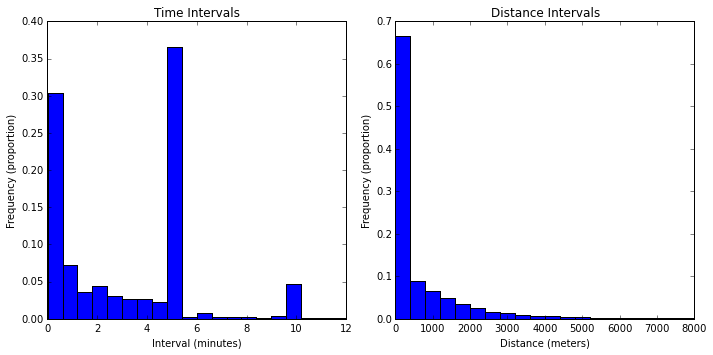

In [6]:
#%% Plotting: Time -- plots a histogram time intervals with 
#                     proportions summing to 1
print "Plotting time intervals..."
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].set_xlabel('Interval (minutes)')
axes[0].set_ylabel('Frequency (proportion)')
axes[0].set_title('Time Intervals')

hist, bins = np.histogram(time_intervals[(time_intervals > 0) & \
            (time_intervals < 12)].astype(np.ndarray), bins=20)
axes[0].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))

distances.dropna(inplace=True)

#% Plotting: Distance -- plots a normed histogram of distance intervals
hist, bins = np.histogram(distances[distances[0] < 8000][0].values, bins=20)

axes[1].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))
axes[1].set_xlabel('Distance (meters)')
axes[1].set_ylabel('Frequency (proportion)')
axes[1].set_title('Distance Intervals')

fig.tight_layout()

# Position density

The following two plots are two-dimensional histograms. 
Density is plotted as a function of latitude and longitude. 
Not surprisingly, the data mostly lie on major roads and highways. 

## Beijing Overview

Plotting position density...


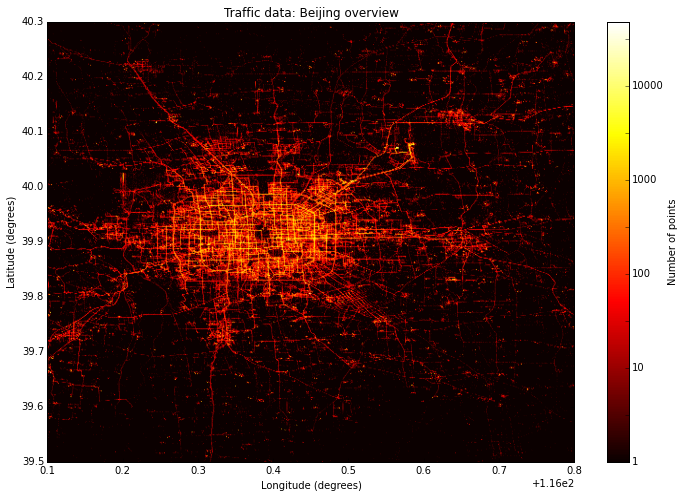

In [ ]:
#%% Plot position density -- Overview 

print "Plotting position density..."
xmin, xmax = 116.1, 116.8
ymin, ymax = 39.5, 40.3

window = data[(xmin < data.longitude) & (data.longitude < xmax) & \
            (ymin < data.latitude) & ( data.latitude < ymax)]

x = np.array(window.longitude)
y = np.array(window.latitude)

plt.figure(figsize = (10,7), dpi=150)
plt.hexbin(x,y,bins='log', gridsize=800, cmap=plt.cm.hot)   # black -> red > white
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data: Beijing overview")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

cb = plt.colorbar(format=LogFormatterHB())
cb.set_label('Number of points')

plt.tight_layout()
plt.show()

## 5th Ring Road in Beijing

Cities in China use concentric ring roads centered on the city center. 
This plot provides a detailed look at the city. 

In [ ]:
# Location details
xmin, xmax = 116.25, 116.5
ymin, ymax = 39.75, 40.1

window = data[(xmin < data.longitude) & (data.longitude < xmax) & \
            (ymin < data.latitude) & ( data.latitude < ymax)]

x = np.array(window.longitude)
y = np.array(window.latitude)

plt.figure(figsize = (10,7), dpi=150)
plt.hexbin(x,y, bins='log', gridsize=800, cmap=plt.cm.hot)   # black -> red > white
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data for Beijing's 5th Ring Road")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

cb = plt.colorbar(format=LogFormatterHB())
cb.set_label('Number of points')

plt.tight_layout()
plt.show()

Let's zoom in to one particular taxi and look at its trajectory. To identify one trip, I manually plotted the distance intervals and defined a trip as starting with 0 speed and ending with 0 speed. 

The taxi may well have been at a long stoplight and may have been empty. It would be an interesting challenge to classify the taxi's state based on the data:

1. Driving a passenger 
2. Waiting for a passenger
3. Driving without a passenger



In [ ]:
#%% Kalman Filter and plot taxi trip
one_taxi = data[data.taxi_id == 1131]

start_index = 38
end_index = 69

measurements = np.asarray([one_taxi.longitude, one_taxi.latitude])
measurements = measurements.T[start_index:end_index]
kf = KalmanFilter(initial_state_mean = measurements[0], \
           n_dim_obs=2, n_dim_state=2)

kf = kf.em(measurements)
#(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

#plt.plot(filtered_state_means.T[0],filtered_state_means.T[1])
plt.plot(smoothed_state_means.T[0],smoothed_state_means.T[1])
plt.title("One Trip smoothed with Karman Filter")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
print "Taxi data for Taxi ID: %d" % one_taxi.taxi_id[0]
print "Start date and time: ", one_taxi.date_time[start_index]
print "Duration:", one_taxi.date_time[end_index] - one_taxi.date_time[start_index]


To give a sense of the larger picture, we'll plot one taxi's trajectory over a longer time span.

In [ ]:
#%% Kalman Filter and plot results
one_taxi = data[data.taxi_id == 1131]

start_index = 0
end_index = 800

measurements = np.asarray([one_taxi.longitude, one_taxi.latitude])
measurements = measurements.T[start_index:end_index]
kf = KalmanFilter(initial_state_mean = measurements[0], \
           n_dim_obs=2, n_dim_state=2)

kf = kf.em(measurements)
#(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

#plt.plot(filtered_state_means.T[0],filtered_state_means.T[1])
plt.plot(smoothed_state_means.T[0],smoothed_state_means.T[1])
plt.title("Many trips smoothed with Karman Filter")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
print "Taxi data for Taxi ID: %d" % one_taxi.taxi_id[0]
print "Start date and time: ", one_taxi.date_time[start_index]
print "Duration:", one_taxi.date_time[end_index] - one_taxi.date_time[start_index]